In [1]:
%matplotlib inline
import io
import sys
import os
import numpy as np
import json
import subprocess
import base64
from scipy.spatial.transform import Rotation as RotationS

pyrobot_path = os.path.expanduser("~/pyrobot/src")
sys.path.append(pyrobot_path)
from pyrobot.core import Robot
from pyrobot import util
import numpy as np
import tf
bot = Robot("tm700")
listenser = tf.TransformListener()
import rospy

source_frame = 'camera_color_optical_frame'
target_frame = 'base_link'

def grasp2pts(x):
    x_mean = x.mean(axis=0)
    x_up = (x[0]+x[1])/2.0
    return (x_mean, x_up)

class GraspHandler(object):
    def __init__(self, grasp_provider="./grasp_provider.py"):
        self.sub_process = subprocess.Popen((grasp_provider,), stdout=subprocess.PIPE, stdin=subprocess.PIPE)
    def get(self, img, depth):
        with io.BytesIO() as fp:
            np.save(fp, img, allow_pickle=True, fix_imports=True)
            img_b64 = base64.b64encode(fp.getvalue()).decode("utf-8")
        with io.BytesIO() as fp:
            np.save(fp, depth, allow_pickle=True, fix_imports=True)
            depth_b64 = base64.b64encode(fp.getvalue()).decode("utf-8")

        command = img_b64 + " " + depth_b64 + "\n"
        self.sub_process.stdin.write(command.encode())
        response = self.sub_process.stdout.readline().decode("utf-8")
        return json.loads(response)
    def best_grasp(self, img, depth):
        return self.get_topK(img, depth, K=1)[0]
    def get_topK(self, img, depth, K=5):
        all_grasp = []
        all_score = []
        results = self.get(img, depth)
        grasps = results['grasp']
        scores = results['confidence']
        for i, grasp_c in enumerate(grasps):
            for j, grasp_b in enumerate(grasp_c):
                x, y = np.asarray(grasp_b, dtype=np.float32).mean(axis=0).astype(np.int32).tolist()
                x = min(img.shape[1]-1, max(0, x))
                y = min(img.shape[0]-1, max(0, y))
                if depth[y,x]<=0.1:
                    continue
                all_grasp.append( grasp_b )
                all_score.append( -scores[i][j] )
        all_grasp = np.asarray(all_grasp)
        return all_grasp[np.argsort(all_score)[:K]]
    def __del__(self):
        self.sub_process.kill()

In [2]:
def get_xyz_transform(listenser, target_frame, source_frame):
    '''
    listenser: tf listenser
    target_frame: base
    source_frame: camera
    ---
    tuple: (trans, quat)
    -- trans: tranlation matrix (3,), tx,ty,tz
    -- quat: quaternion (4,) x,y,z,w
    '''
    try:
        now = rospy.Time.now()
        listenser.waitForTransform(target_frame, source_frame, now, rospy.Duration(10))
        trans, quat = listenser.lookupTransform(target_frame, source_frame, now)
        #print(trans) #tx, ty, tz
        #print(quat) # i, j, k ,w
    except (tf.LookupException,
                tf.ConnectivityException,
                tf.ExtrapolationException):
            raise RuntimeError('Cannot fetch the transform from {0:s} to {1:s}'.format(source_frame, target_frame))
    return trans, quat 

def transform_pts(pts, trans, quat):
    '''
    pts: (N,3) -- x,y,z
    trans: (3,) -- translation matrix
    quat: (4,) -- quanternion (rotation)
    ---
    rpts: (N,3) -- transformed x,y,z
    '''
    R = RotationS.from_quat(quat)
    return R.apply(pts) + np.asarray(trans,dtype=pts.dtype)[np.newaxis]

def transform_pts_wrt_base_link(pts, listenser, target_frame, source_frame, return_transform=False):
    trans, quat = get_xyz_transform(listenser, target_frame, source_frame)
    return transform_pts(pts, trans, quat) if not return_transform else (transform_pts(pts, trans, quat), trans, quat)

def get_xyz_rgb(bot):
    '''
    bot: Robot tm700
    ---
    rpts: ndarray (H, W, 3) -- x, y, z
    '''
    mat, _, _ = bot.camera.get_intrinsics()
    rgb, depth = bot.camera.get_rgb_depth()
    none_region = (depth==0)
    mat_inv = np.linalg.inv(mat) # (3,3)
    depth = depth / 1e3
    y = np.arange(0, depth.shape[0])
    x = np.arange(0, depth.shape[1])
    xv, yv = np.meshgrid(x, y)
    xy = np.append(xv[np.newaxis], yv[np.newaxis], axis=0) # (2, H, W) -- xy
    xy_homogeneous = np.pad(xy, ((0,1),(0,0),(0,0)), mode='constant', constant_values=1) # (3, H, W) -- x, y, 1
    xy_homogeneous_shape = xy_homogeneous.shape
    xy_h_flat = xy_homogeneous.reshape(3, -1) # (3, H*W) -- x, y, 1
    xy_h_flat_t = np.dot(mat_inv, xy_h_flat) # (3,3) x (3, H*W) -> (3, H*W)
    xy_homogeneous_t = xy_h_flat_t.reshape(xy_homogeneous_shape) # (3, H, W)
    xyz = np.transpose(xy_homogeneous_t*depth[np.newaxis], (1,2,0)) # (H, W, 3) -- x, y, z
    xyz[none_region,-1] = np.min(xyz[~none_region,-1])
    return xyz, rgb

def get_heightmap(bot, listenser, target_frame='base_link', source_frame='camera_color_optical_frame', return_transform=False):
    xyz, rgb = get_xyz_rgb(bot) # (H, W, 3)
    xyz_shape = xyz.shape
    xyz_f = xyz.reshape(-1, 3) # (H*W, 3)
    xyz_transformed, trans, quant = transform_pts_wrt_base_link(xyz_f, listenser, target_frame=target_frame, source_frame=source_frame, return_transform=True)
    xyz_transformed = xyz_transformed.reshape(xyz_shape)
    return (xyz_transformed, rgb) if not return_transform else (xyz_transformed, rgb, trans, quant)

def process_heighmap_range(heightmap, lower=-0.03, upper=0.13):
    depth_ = heightmap.copy()
    invalid_region = ((depth_<lower) | (depth_>upper))
    depth_ = (depth_.clip(lower, upper) - lower) / (upper-lower)
    depth_[invalid_region] = 0
    return depth_

In [3]:
test = GraspHandler()

In [9]:
import cv2
import matplotlib.pyplot as plt
xyz, img = get_heightmap(bot, listenser, target_frame=target_frame, source_frame=source_frame)
depth = xyz[...,-1]
depth = process_heighmap_range(depth, lower=-0.03, upper=0.15)
depth[:400] = 0
depth[:,:400] = 0
img[depth==0] = 140


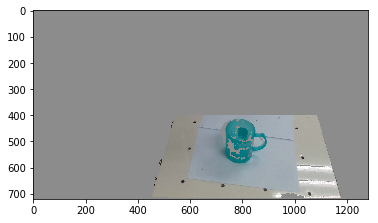

In [10]:
plt.imshow(img)
plt.show()

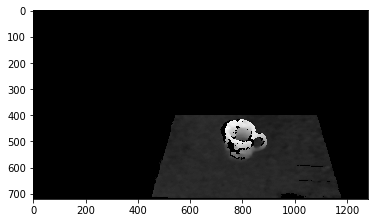

In [11]:
plt.imshow(depth, cmap='gray')
plt.show()

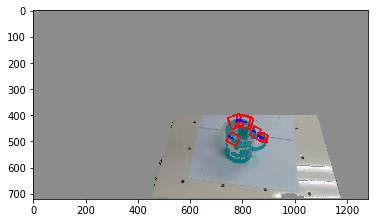

In [12]:
pts = test.get_topK(img,depth,K=10)
img_ = np.copy(img)
cv2.polylines(img_, pts.astype(np.int32), True, (255,0,0), 5)
vecs = [ grasp2pts(pt) for pt in pts ]
for vec in vecs:
    cv2.line(img_, tuple(vec[0].astype(np.int32)), tuple(vec[1].astype(np.int32)), (0,0,255), 5)
plt.imshow(img_)
plt.show()

In [19]:
def deg_diff(u_, v_):
    u = u_.astype(np.float32)
    v = v_.astype(np.float32)
    costha = np.sum(u*v) / (np.linalg.norm(u)*np.linalg.norm(v))
    rad = np.arccos(costha)
    return rad

def apply_grasp_pose(bot, xyz, x0_, x1_, target_frame, listener):
    x0 = x0_.astype(np.int32)
    x1 = x1_.astype(np.int32)
    pt1_ = xyz[x0[1],x0[0]] # grasp in base_link
    pt1, height = pt1_[:2], pt1_[2]
    pt2 = xyz[x1[1],x1[0]][:2] # grasp in base_link
    u = np.array([0,10],dtype=np.float32)
    v = pt2-pt1
    if v[1]<0:
        v = -v
    print(v)
    rad = deg_diff(u,v)
    if v[0]<0:
        rad = -rad
    print(np.degrees(rad))
    rot_grasp = tf.transformations.euler_matrix(0, 0, rad)
    rot_grasp = tf.transformations.quaternion_from_matrix(rot_grasp)
    # pose = bot.arm.get_ee_pose()
    trans, quat = util.get_tf_transform(listener, target_frame, target_frame)
    quat = np.array(quat)
    # rotate orientation by y
    rot = tf.transformations.euler_matrix(0, np.pi, 0)
    rot = tf.transformations.quaternion_from_matrix(rot)
    quat = tf.transformations.quaternion_multiply(rot_grasp, quat)
    quat = tf.transformations.quaternion_multiply(rot, quat)
    #quat = tf.transformations.quaternion_multiply(rot_grasp, quat)
    final_r = RotationS.from_quat(np.asarray(quat)).as_euler('xyz', degrees=True).clip(-177,177)
    quat = RotationS.from_euler('xyz', final_r, degrees=True).as_quat()

    trans = np.array([pt1[0], pt1[1], 0.25])
    print(trans, final_r.astype(np.int32))
    bot.arm.set_ee_pose(trans, quat)

[0.01744652 0.01034973]
59.322483
(array([-0.11153357,  0.35843911,  0.25      ]), array([177,   0, 120], dtype=int32))
[INFO] [1565070895.864552]: Moveit Motion Planning...
[INFO] [1565070895.986915]: Executing...


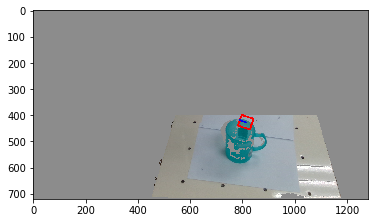

In [20]:
#for i in range(len(pts)):
for i in [0]:
    best_grasp = grasp2pts(pts[i])
    apply_grasp_pose(bot, xyz, best_grasp[0], best_grasp[1], target_frame, listenser)
    img_ = np.copy(img)
    cv2.polylines(img_, [pts[i].astype(np.int32)], True, (255,0,0), 5)
    pt = grasp2pts(pts[i])
    cv2.line(img_, tuple(pt[0].astype(np.int32)), tuple(pt[1].astype(np.int32)), (0,0,255), 5)
    plt.imshow(img_)
    plt.show()